# Random Forest Modelling

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler


### Mengecek dataset setelah dilakukan fitur seleksi

In [25]:
train = pd.read_csv('../dataset/after_selection/train.csv')



In [26]:
train.shape

(90310, 9)

In [27]:
train.head()

,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Policy_Sales_Channel,Age_Bin,Vehicle_Damage_Age_Interaction,Response
0,1,46.0,1,0,0,152.0,0,0,0
1,1,46.0,1,0,0,152.0,0,0,0
2,1,46.0,1,1,1,26.0,2,2,0
3,1,18.0,1,0,0,152.0,1,0,0
4,1,11.0,0,1,1,122.0,2,2,0


### Memisah feature dan target 

In [28]:
training_data, testing_data = train.drop(columns=['Response']),train['Response']

### Membuat data test dan training dengan perbandingan 20:80

In [29]:
X_train, X_test, y_train, y_test = train_test_split(training_data,testing_data, test_size=0.2, random_state=42)

In [30]:
X_train.head()

,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Policy_Sales_Channel,Age_Bin,Vehicle_Damage_Age_Interaction
20496,1,48.0,0,1,1,26.0,2,2
61232,1,28.0,0,2,1,26.0,2,2
63399,1,46.0,0,1,1,124.0,2,2
15134,1,16.0,0,0,0,152.0,0,0
467,1,28.0,1,1,0,55.0,2,0


In [31]:
X_train.shape

(72248, 8)

## Modelling dangan Random Forest Classifier

In [32]:
# Inisialisasi model
rf_model = RandomForestClassifier(random_state=42)

# Latih model pada data latih
rf_model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

## Hasil Prediksi

In [33]:
# Lakukan prediksi pada data uji
y_pred = rf_model.predict(X_test)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_validate, StratifiedKFold


def eval_classification(model, X_train, X_test, y_train, y_test, n_splits=5):
    # Evaluate on the test set
    y_pred_test = model.predict(X_test)

    # StratifiedKFold for cross-validation with stratified sampling
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Perform cross-validation
    cv_test_results = cross_validate(model, X_test, y_test, scoring=['roc_auc'],
                                cv=cv, return_train_score=False)
    cv_train_results = cross_validate(model, X_train, y_train, scoring=['roc_auc'],
                                cv=cv, return_train_score=False)
    

    # Display metrics for the training set
    print("Metrics for the Test Set:")
    print("Accuracy: %.2f" % accuracy_score(y_test, y_pred_test))
    print("Precision: %.2f" % precision_score(y_test, y_pred_test))
    print("Recall: %.2f" % recall_score(y_test, y_pred_test))
    print("F1-Score: %.2f" % f1_score(y_test, y_pred_test))
    print()

    # Display cross-validation results
    print("Metrics Using Cross Validation:")
    print(f"Mean ROC-AUC (Test): {cv_test_results['test_roc_auc'].mean():.2f}")
    print(f"Std ROC-AUC (Test): {cv_test_results['test_roc_auc'].std():.2f}")
    print()
    print(f"Mean ROC-AUC (Train): {cv_train_results['test_roc_auc'].mean():.2f}")
    print(f"Std ROC-AUC (Train): {cv_train_results['test_roc_auc'].std():.2f}")

In [34]:
eval_classification(rf_model, X_train, X_test, y_train, y_test)

Metrics for the Test Set:
Accuracy: 0.79
Precision: 0.73
Recall: 0.92
F1-Score: 0.82

Metrics Using Cross Validation:
Mean ROC-AUC (Test): 0.82
Std ROC-AUC (Test): 0.01

Mean ROC-AUC (Train): 0.84
Std ROC-AUC (Train): 0.00


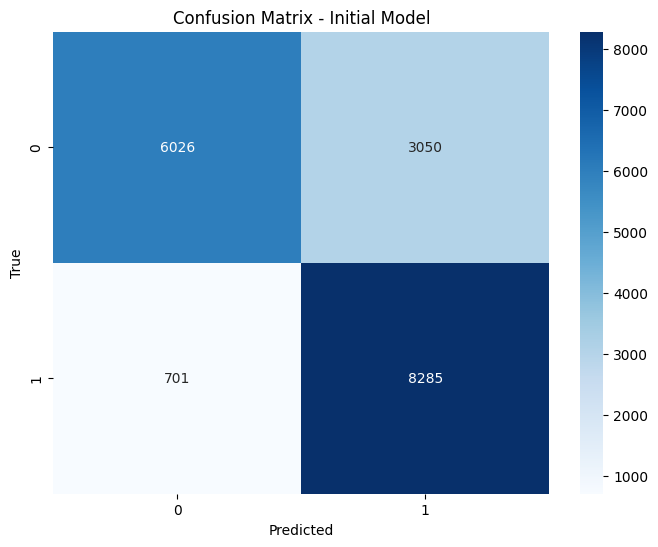

In [35]:
from sklearn.metrics import confusion_matrix

# Fungsi untuk plot matriks konfusi
def plot_confusion_matrix(y_true, y_pred, classes, title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Plot matriks konfusi untuk model awal
plot_confusion_matrix(y_test, y_pred, classes=['0', '1'], title='Confusion Matrix - Initial Model')


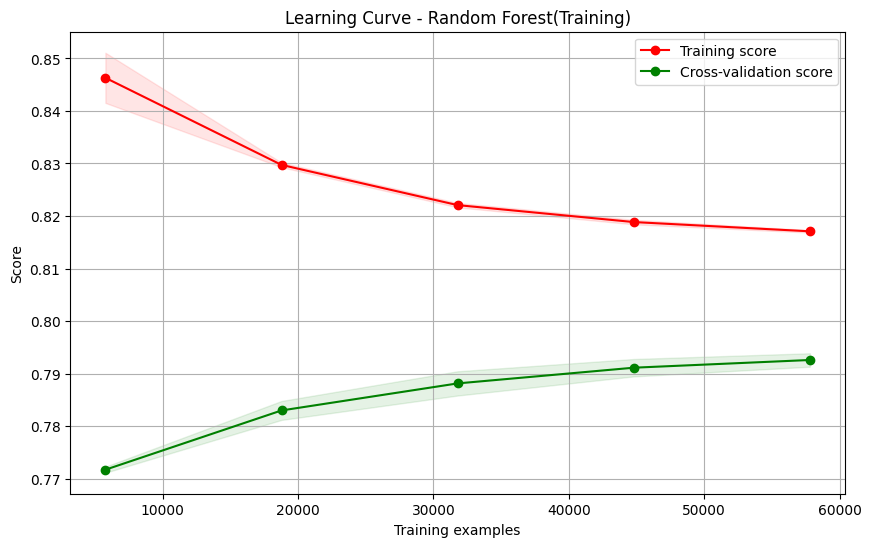

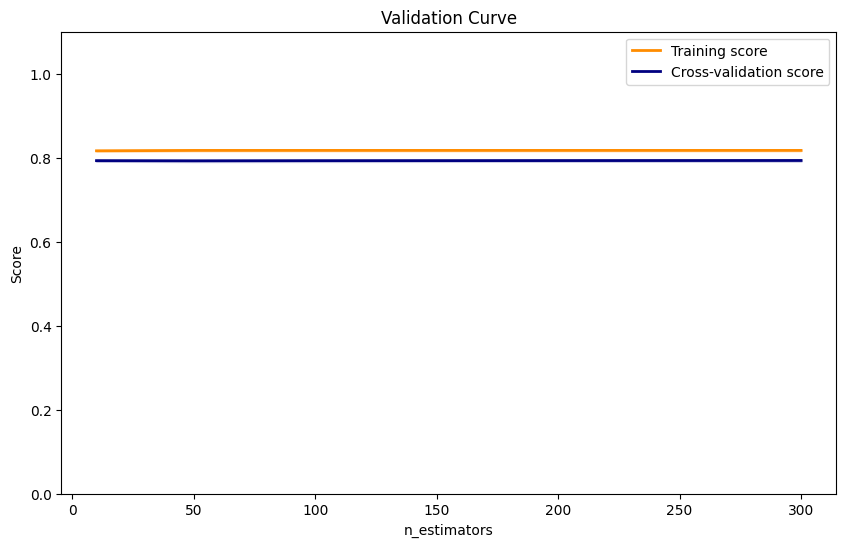

In [36]:
from sklearn.model_selection import learning_curve, validation_curve

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure(figsize=(10, 6))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    return plt

def plot_validation_curve(estimator, X, y, param_name, param_range, cv=5, scoring="accuracy"):
    train_scores, test_scores = validation_curve(
        estimator, X, y, param_name=param_name, param_range=param_range,
        cv=cv, scoring=scoring, n_jobs=-1)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.title("Validation Curve")
    plt.xlabel(param_name)
    plt.ylabel("Score")
    plt.ylim(0.0, 1.1)
    lw = 2

    plt.plot(param_range, train_scores_mean, label="Training score", color="darkorange", lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2, color="darkorange", lw=lw)

    plt.plot(param_range, test_scores_mean, label="Cross-validation score", color="navy", lw=lw)
    plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.2, color="navy", lw=lw)

    plt.legend(loc="best")
    return plt

# Plot Learning Curve Training
title = "Learning Curve - Random Forest(Training)"
plot_learning_curve(rf_model, title, X_train, y_train, cv=5)

# Plot Validation Curve Training
param_range = [10, 50, 100, 200, 300]
plot_validation_curve(rf_model, X_train, y_train, param_name="n_estimators", param_range=param_range, cv=5)

plt.show()

<module 'matplotlib.pyplot' from 'c:\\Users\\Muhammad Iqbal\\AppData\\Local\\Programs\\Python\\Python311\\Lib\\site-packages\\matplotlib\\pyplot.py'>

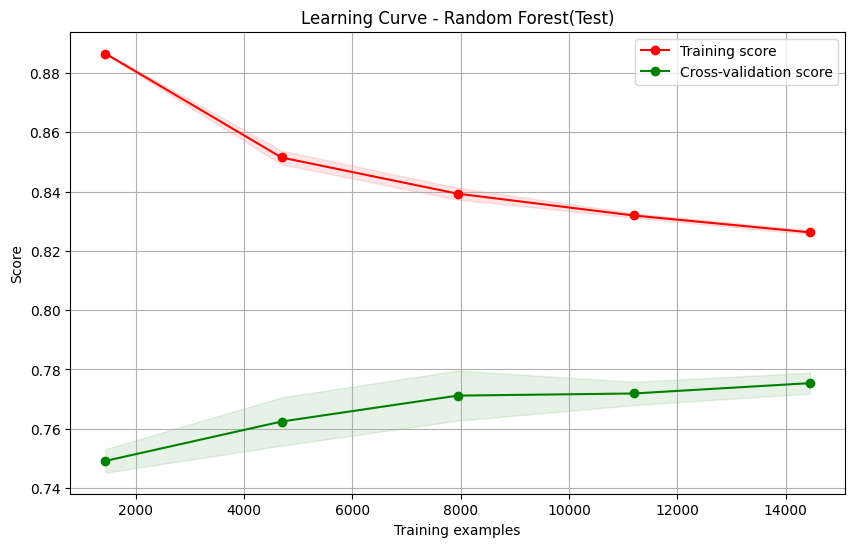

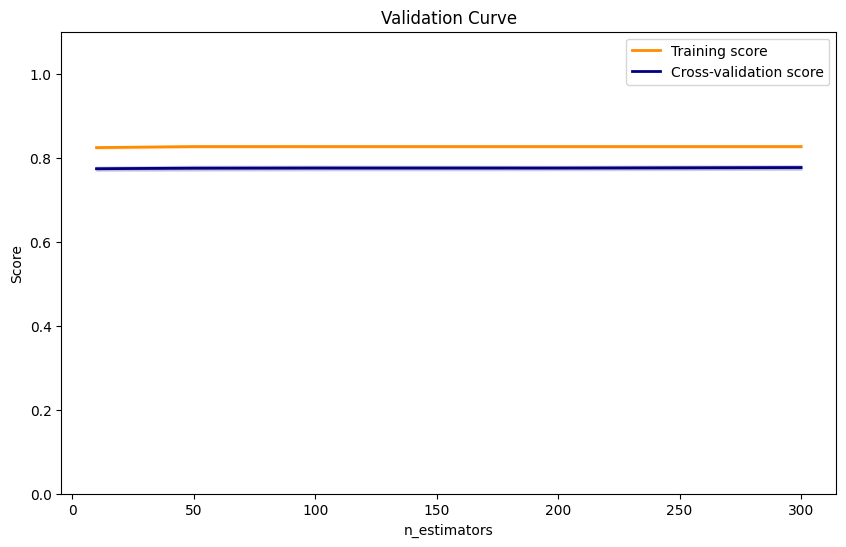

In [37]:
# Plot Learning Curve Test
title = "Learning Curve - Random Forest(Test)"
plot_learning_curve(rf_model, title, X_test, y_test, cv=5)
# Plot Validation Curve Test
param_range = [10, 50, 100, 200, 300]
plot_validation_curve(rf_model, X_test, y_test, param_name="n_estimators", param_range=param_range, cv=5)

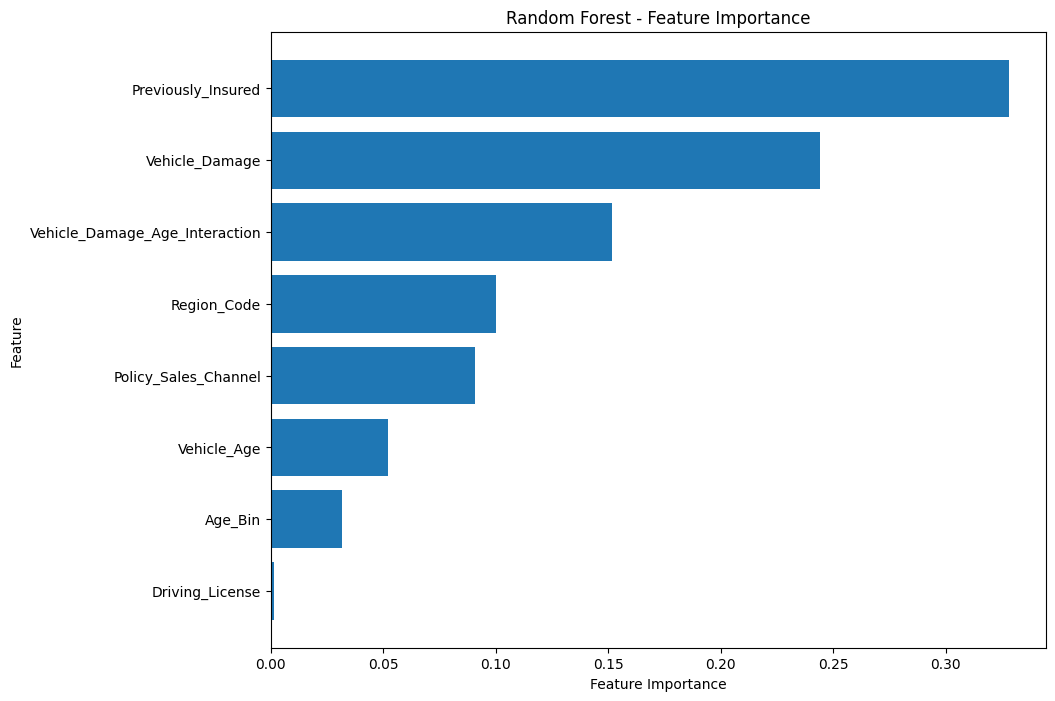

In [38]:
# Mendapatkan feature importance dari model
feature_importance = rf_model.feature_importances_

# Mendapatkan nama fitur
feature_names = X_train.columns

# Mengurutkan indeks fitur berdasarkan feature importance
sorted_idx = np.argsort(feature_importance)

# Plot feature importance
plt.figure(figsize=(10, 8))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align="center")
plt.yticks(range(len(sorted_idx)), feature_names[sorted_idx])
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Random Forest - Feature Importance")
plt.show()

## Tuning

In [39]:
# Tentukan kumpulan hyperparameter yang ingin dioptimalkan
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Inisialisasi model Random Forest
rf_tuned = RandomForestClassifier(random_state=42)

# Inisialisasi GridSearchCV
grid_search = GridSearchCV(estimator=rf_tuned, param_grid=param_grid, cv=5, scoring='accuracy')

# Jalankan GridSearchCV pada data latih
grid_search.fit(X_train, y_train)

# Dapatkan hyperparameter terbaik
best_params = grid_search.best_params_
print(f'Best Hyperparameters: {best_params}')

# Gunakan model dengan hyperparameter terbaik untuk evaluasi
best_rf_model = grid_search.best_estimator_
y_pred_tuned = best_rf_model.predict(X_test)

# Evaluasi akurasi model yang telah disesuaikan
accuracy_tuned = accuracy_score(y_test, y_pred_tuned)
print(f'Tuned Model Accuracy: {accuracy_tuned:.2f}')

Best Hyperparameters: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Tuned Model Accuracy: 0.80


In [40]:
eval_classification(best_rf_model, X_train, X_test, y_train, y_test)

Metrics for the Test Set:
Accuracy: 0.80
Precision: 0.73
Recall: 0.93
F1-Score: 0.82

Metrics Using Cross Validation:
Mean ROC-AUC (Test): 0.84
Std ROC-AUC (Test): 0.01

Mean ROC-AUC (Train): 0.85
Std ROC-AUC (Train): 0.00


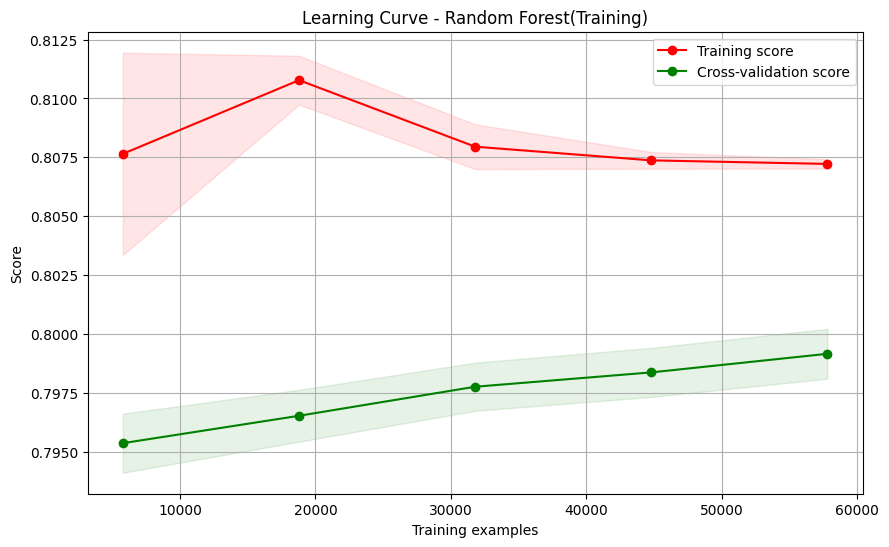

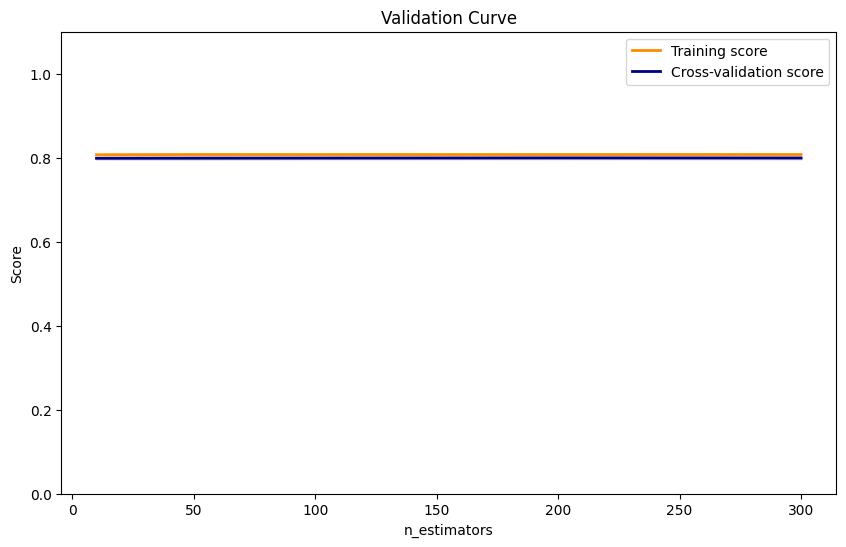

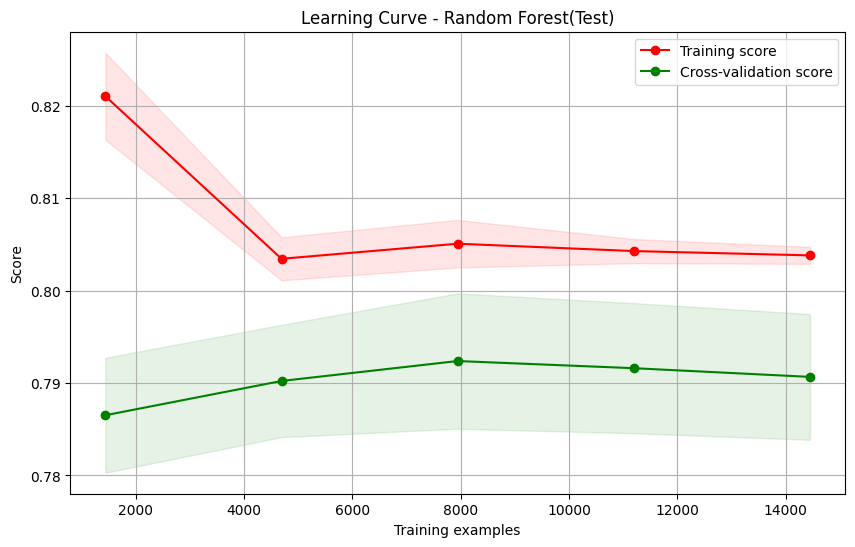

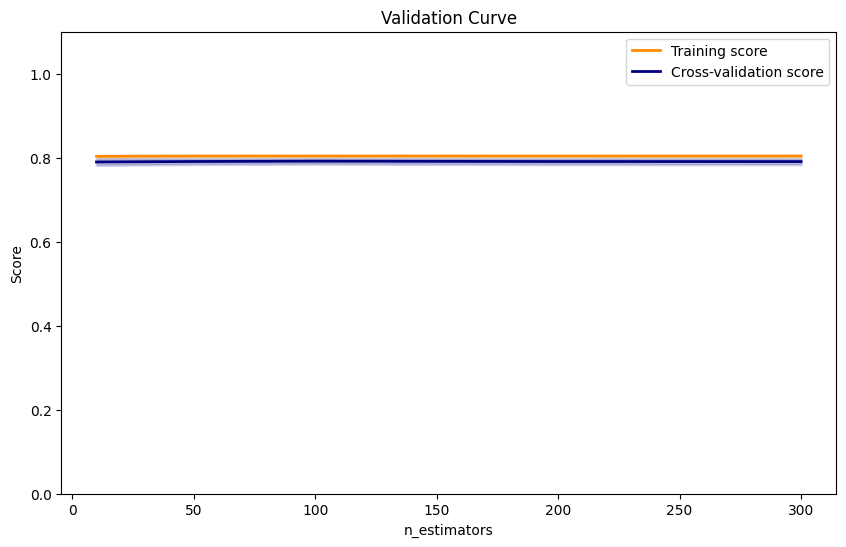

In [41]:
# Plot Learning Curve Training
title = "Learning Curve - Random Forest(Training)"
plot_learning_curve(best_rf_model, title, X_train, y_train, cv=5)

# Plot Validation Curve Training
param_range = [10, 50, 100, 200, 300]
plot_validation_curve(best_rf_model, X_train, y_train, param_name="n_estimators", param_range=param_range, cv=5)

# Plot Learning Curve Test
title = "Learning Curve - Random Forest(Test)"
plot_learning_curve(best_rf_model, title, X_test, y_test, cv=5)
# Plot Validation Curve Test
param_range = [10, 50, 100, 200, 300]
plot_validation_curve(best_rf_model, X_test, y_test, param_name="n_estimators", param_range=param_range, cv=5)


plt.show()

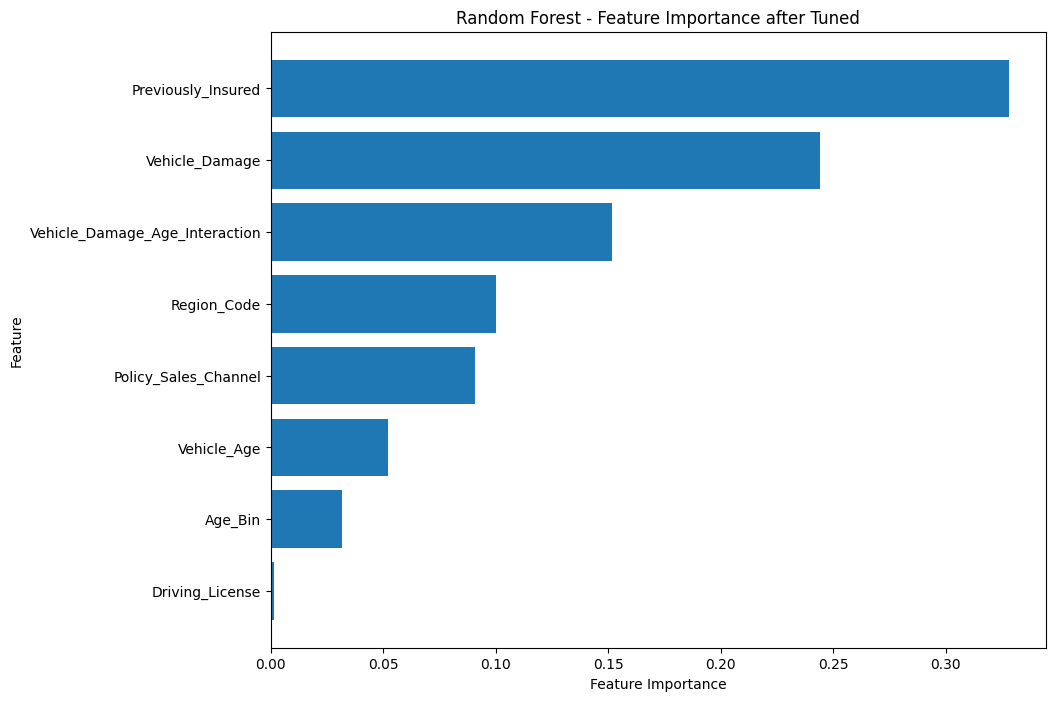

In [42]:
# Mendapatkan feature importance dari model
feature_importance_tuned = best_rf_model.feature_importances_

# Mendapatkan nama fitur
feature_names = X_train.columns

# Mengurutkan indeks fitur berdasarkan feature importance
sorted_idx = np.argsort(feature_importance)

# Plot feature importance
plt.figure(figsize=(10, 8))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align="center")
plt.yticks(range(len(sorted_idx)), feature_names[sorted_idx])
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Random Forest - Feature Importance after Tuned")
plt.show()

## Scalling

In [44]:
# Inisialisasi dan fit StandardScaler pada data latih
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Terapkan transformasi yang sama pada data uji
X_test_scaled = scaler.transform(X_test)

In [45]:

rf_model_scaled = RandomForestClassifier(random_state=42)


rf_model_scaled.fit(X_train_scaled, y_train)


RandomForestClassifier(random_state=42)

In [46]:

y_pred_scaled = rf_model_scaled.predict(X_test_scaled)


accuracy = accuracy_score(y_test, y_pred_scaled)
print(f'Accuracy: {accuracy:.2f}')


print(classification_report(y_test, y_pred_scaled))

Accuracy: 0.79
              precision    recall  f1-score   support

           0       0.90      0.66      0.76      9076
           1       0.73      0.92      0.82      8986

    accuracy                           0.79     18062
   macro avg       0.81      0.79      0.79     18062
weighted avg       0.81      0.79      0.79     18062



Hasil scalling tidak menunjukkan perubahan hasil prediksi maka modelling dangan scalling tidak dilanjutkan